# Analysis

**Hypothesis**: The tutoring program has a differential impact across the distribution of academic outcomes, with its benefits being most pronounced among lower-performing students, thus reducing performance disparities.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings

# Econometrics libraries
import statsmodels.api as sm
import statsmodels.formula.api as smf
try:
    from linearmodels.panel import PanelOLS
except Exception:
    PanelOLS = None

# Visualization defaults
plt.rcParams['figure.figsize'] = (10, 8)
plt.rcParams['savefig.dpi'] = 150
sns.set_style('whitegrid')
sns.set_context('notebook', font_scale=1.2)
warnings.filterwarnings('ignore')

# Load data
print('Loading data...')
df = pd.read_stata('aea_packages/228584_V1/Data_analysis/Data/TOP1_TOP3_Dataset.dta')
print(f"Data loaded: {df.shape[0]} rows and {df.shape[1]} columns")
print('Columns:', list(df.columns)[:20])


Loading data...
Data loaded: 2196 rows and 261 columns
Columns: ['Group_Tutoring', 'ID_student', 'ID_tutor', 'ID_tutor_3', 'SES_5', 'TOP1', 'TOP3', 'always_f_online_classes_pe_1', 'always_f_online_classes_se_1', 'aspirations', 'aspirations_uni_pe', 'aspirations_uni_se', 'aspirations_uni_te', 'barrier_money_sb', 'barrier_parents_sb', 'barrier_self_sb', 'choice_prof_se', 'choose_topliceo_se', 'choose_vocational_se', 'comp_skills_tub']


# Analysis Plan

**Hypothesis**: The tutoring program has a differential impact across the distribution of academic outcomes, with its benefits being most pronounced among lower-performing students, thus reducing performance disparities.

## Steps:
- Perform an enhanced exploratory data analysis of math performance (grade_mat_admin_endline) by treatment status. This step computes summary statistics by group and generates density plots, histograms, and boxplots to inspect distribution shapes, potential outliers, and multimodality.
- Estimate a baseline OLS regression of the math outcome on the treatment indicator along with key controls (such as baseline test scores, SES, and other student characteristics) to provide a conventional average treatment effect estimate.
- Perform quantile regression analyses at various quantiles (e.g., 10th, 25th, 50th, 75th, and 90th percentiles) to determine if the impact of the tutoring program is larger at lower quantiles of academic achievement.
- Visualize the quantile regression coefficients along with their confidence intervals in a coefficient plot to illustrate how the treatment effect varies across the performance distribution.
- Conduct a robustness check by re-estimating the quantile regressions with an alternative specification that uses a continuous measure of tutoring dose (e.g., duration_total) instead of the binary treatment indicator.


## This code computes summary statistics of the math performance variable by treatment group and then creates density plots to visualize the overall distribution differences. It further complements these plots with a histogram and boxplot to inspect for outliers and potential multimodality in the data.

Summary Statistics by Treatment:
   treat      mean  median       std
0      0  6.171266     6.0  1.086354
1      1  6.236702     6.0  1.025756


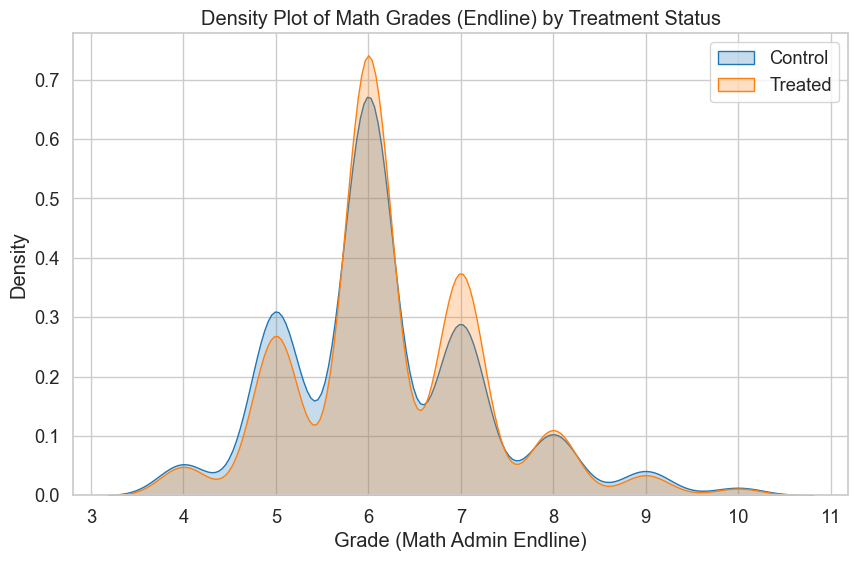

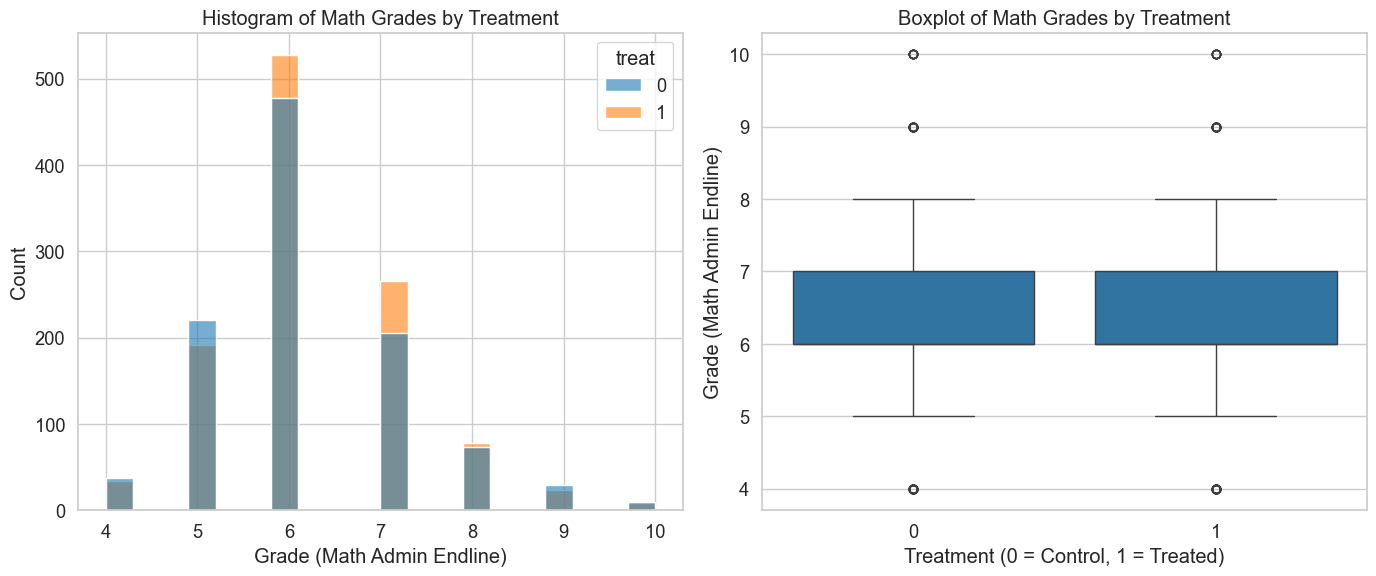

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Drop missing values for the outcome and treatment variable
eda_df = df[['grade_mat_admin_endline', 'treat']].dropna()

# Compute summary statistics (mean, median, std) by treatment group
summary_stats = eda_df.groupby('treat')['grade_mat_admin_endline'].agg(['mean', 'median', 'std']).reset_index()
print('Summary Statistics by Treatment:')
print(summary_stats)

# Plot density distributions of grade_mat_admin_endline by treatment status
plt.figure(figsize=(10, 6))
for treatment in eda_df['treat'].unique():
    subset = eda_df[eda_df['treat'] == treatment]
    label = 'Treated' if treatment == 1 else 'Control'
    sns.kdeplot(subset['grade_mat_admin_endline'], shade=True, label=label)
plt.title('Density Plot of Math Grades (Endline) by Treatment Status')
plt.xlabel('Grade (Math Admin Endline)')
plt.ylabel('Density')
plt.legend()
plt.show()

# Additionally, plot a histogram and boxplot to examine distributional features and potential outliers
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.histplot(data=eda_df, x='grade_mat_admin_endline', hue='treat', kde=False, ax=axes[0], alpha=0.6, bins=20)
axes[0].set_title('Histogram of Math Grades by Treatment')
axes[0].set_xlabel('Grade (Math Admin Endline)')
axes[0].set_ylabel('Count')

sns.boxplot(x='treat', y='grade_mat_admin_endline', data=eda_df, ax=axes[1])
axes[1].set_title('Boxplot of Math Grades by Treatment')
axes[1].set_xlabel('Treatment (0 = Control, 1 = Treated)')
axes[1].set_ylabel('Grade (Math Admin Endline)')

plt.tight_layout()
plt.show()

### Agent Interpretation

The exploratory data analysis provides an initial view of the treatment and control group distributions, showing slight visual differences in the KDE and histograms. Key observations and recommendations for future steps include:

1. **Summary Statistics:**
   - The means and medians are almost identical for both groups, with a slightly higher mean in the treatment group, suggesting a minimal average effect.
   - Standard deviations are similar, indicating comparable dispersion.

2. **Density Plot:**
   - The distribution shapes hint at multimodality, especially around the grade of 6. This could affect the validity of standard OLS assumptions and further justifies the use of quantile regression to explore impact across the distribution.

3. **Histogram and Boxplots:**
   - Both treatment and control groups have similar central tendencies and variability.
   - There are some outliers, particularly above a grade of 8, which should be noted in further analyses.

4. **Identified Next Steps:**
   - **Baseline OLS Regression:** Follow up with OLS to establish an average treatment effect with controls. Important for identifying any mean-based discrepancies.
   - **Quantile Regression:** Essential to support the hypothesis that lower-performing students benefit more. Confirm if impact varies across quantiles, particularly the lower ones. 
   - **Robustness Checks:** Consider alternative measures like tutoring duration to verify results' consistency.

5. **Identification and Validity:**
   - Ensure robustness of the analysis by checking assumptions underlying the quantile regression.
   - Account for potential attrition bias as noted in the original study—excluding or adjusting for missing data where applicable.

In summary, while initial EDA suggests minimal average impact, further analysis via quantile regression is crucial to test the hypothesis regarding differential impacts across performance quantiles.

## This code fits an OLS regression using robust standard errors to determine the treatment effect on endline math scores and explicitly tests whether the interaction between treatment and baseline math scores indicates greater benefits for lower-performing students. Comments highlight potential sample selection issues from missing data.

In [ ]:
import statsmodels.formula.api as smf

# Prepare the data: drop rows with missing values for crucial variables; note that non-random missingness could introduce sample selection bias
ols_df = df[['grade_mat_admin_endline', 'treat', 'grade_mat_admin_baseline', 'SES_5']].dropna()

# Define the regression formula. The interaction term (treat:grade_mat_admin_baseline) is key: a negative coefficient would indicate that lower baseline scores are associated with higher gains from tutoring
formula = 'grade_mat_admin_endline ~ treat + grade_mat_admin_baseline + SES_5 + treat:grade_mat_admin_baseline'

# Fit the OLS model with robust standard errors to account for potential heteroskedasticity
ols_model = smf.ols(formula, data=ols_df).fit(cov_type='HC1')

# Print the regression results, with special attention to the interaction coefficient
print(ols_model.summary())

                               OLS Regression Results                              
Dep. Variable:     grade_mat_admin_endline   R-squared:                       0.238
Model:                                 OLS   Adj. R-squared:                  0.236
Method:                      Least Squares   F-statistic:                     85.39
Date:                     Wed, 08 Oct 2025   Prob (F-statistic):           1.44e-65
Time:                             10:30:06   Log-Likelihood:                -2075.6
No. Observations:                     1546   AIC:                             4161.
Df Residuals:                         1541   BIC:                             4188.
Df Model:                                4                                         
Covariance Type:                       HC1                                         
                                     coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------

### Agent Interpretation

Based on the results of the OLS regression, there are several key points and suggestions for next steps in this analysis:

1. **Interaction Term and Hypothesis Testing:**
   - The key focus of this step is the interaction term (treat:grade_mat_admin_baseline). The coefficient for this term is -0.0431, but it is not statistically significant (p-value = 0.401). This finding does not provide evidence to support the hypothesis that lower-performing students benefit more from the tutoring program. However, the wide confidence interval suggests that the estimate is imprecise, which merits further investigation.

2. **Identification and Credibility:**
   - The hypothesis is grounded in exploring heterogeneity in treatment effects, but the non-significant result suggests potential issues in either the model specification, sample size, or variability in the data.
   - The R-squared value is 0.238, which indicates that the model explains a modest amount of variation in endline math scores. Consider exploring additional covariates or alternative model specifications to capture more variation.
   - The dataset has dropped observations with missing values. Since there's a concern for non-random missingness, it is crucial to assess if this might bias the results, potentially affecting the interaction term.

3. **Effect Sizes and Standard Errors:**
   - The coefficient for the interaction term is small, and its standard error (0.051) is relatively large compared to the estimated effect size. This implies low precision in estimating the interaction effect.

4. **Next Steps:**
   - **Assess Sample Selection Bias:** Perform diagnostic checks and implement methods such as inverse probability weighting or imputation techniques to account for potential biases due to missing data.
   - **Subgroup Analysis:** Proceed with the plan to conduct subgroup analyses by splitting the sample at the median baseline math score. This step can provide clearer insights into differential effects between lower-performing and higher-performing students.
   - **Machine Learning Approach:** Implement the Random Forest regression model to explore non-linear relationships and potential interactions that could be overlooked by the linear OLS model.
   - **Robustness Checks:** Re-estimate the baseline OLS using a continuous measure of tutoring dose to assess the robustness of findings across different treatment intensities.
   - **Visualization:** Visualize these interactions and heterogeneities to aid in interpreting the results, especially in communicating them to non-technical audiences.

5. **Consider Broader Context:**
   - Keep in mind the context and any other external factors that might impact the interpretation of results, especially as previous studies (e.g., NBER Working Paper 32272) noted differences between online and in-person settings and the role of volunteer tutors.

Overall, the current analysis step lays a foundation but requires additional exploration and methodological rigor to fully address the hypothesis regarding differential impacts on lower-performing students.

## This code prepares the dataset by dropping missing values (while reporting the number of dropped observations), and then fits quantile regression models at selected quantiles. It extracts coefficients, robust standard errors, and 95% confidence intervals for each quantile, storing them in a dictionary for future visualizations and analysis.

In [ ]:
import statsmodels.formula.api as smf

# Prepare data by dropping missing values for variables of interest and report number of dropped observations
vars_of_interest = ['grade_mat_admin_endline', 'treat', 'grade_mat_admin_baseline', 'SES_5']
initial_count = len(df)
qr_df = df[vars_of_interest].dropna()
dropped_count = initial_count - len(qr_df)
print(f'Number of observations dropped due to missing values: {dropped_count}')

# Specify the quantiles to evaluate
quantiles = [0.1, 0.25, 0.5, 0.75, 0.9]

# Define the regression formula including the interaction term
template_formula = 'grade_mat_admin_endline ~ treat + grade_mat_admin_baseline + SES_5 + treat:grade_mat_admin_baseline'

# Fit quantile regressions for each quantile and extract coefficients, standard errors, and confidence intervals
qr_results = {}
for q in quantiles:
    mod = smf.quantreg(template_formula, data=qr_df)
    res = mod.fit(q=q)
    coeff = res.params
    se = res.bse
    ci = res.conf_int()
    qr_results[q] = {'coefficients': coeff, 'std_errors': se, 'conf_int': ci}

    print(f'\nQuantile {q} regression results:')
    print(res.summary())

# The dictionary 'qr_results' now holds the full set of estimates needed for subsequent visualization and robustness checks.

Number of observations dropped due to missing values: 650

Quantile 0.1 regression results:
                            QuantReg Regression Results                            
Dep. Variable:     grade_mat_admin_endline   Pseudo R-squared:              0.01763
Model:                            QuantReg   Bandwidth:                      0.2600
Method:                      Least Squares   Sparsity:                        3.647
Date:                     Wed, 08 Oct 2025   No. Observations:                 1546
Time:                             10:31:18   Df Residuals:                     1541
                                             Df Model:                            4
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept                          3.0000      0.230     13.029      0.000       2.548       3.452
treat                  

### Agent Interpretation

**Feedback on Current Analysis:**

1. **Identification and Selection Bias:**
   - The data preparation phase reports a significant number of observations dropped due to missing values (650). This could introduce selection bias if the missing data are non-random or systematically related to key variables such as treatment assignment or baseline scores. It would be crucial to assess whether the missing data pattern could influence your results and consider methods like multiple imputation to address potential biases.

2. **Quantile Regression Results:**
   - At the 10th quantile, the coefficients for `treat` and `treat:grade_mat_admin_baseline` are not statistically significant (p-values ~1.000), suggesting no observable treatment effect at this quantile. The very small magnitude of `SE` suggests potential issues with model specification or data variability at this quantile.
   - The 25th quantile shows a significant and negative interaction effect (`treat:grade_mat_admin_baseline`), consistent with the hypothesis. This indicates the tutoring program may indeed have been more beneficial for students with lower baseline scores in this quantile.
   - At the median (50th quantile), the `treat` coefficient is negative and statistically significant, contrary to the hypothesis. The interaction term is positive, suggesting that while the treatment alone might negatively impact this group, its effect is enhanced positively when interacting with prior baseline scores.
   - For the higher quantiles (75th and 90th), coefficients associated with treatment and interaction effects are not significant, implying less impact in higher score ranges.

3. **Effect Size and Robustness:**
   - Effect sizes vary across the distribution, with significant coefficients at the lower quantiles supporting the hypothesis. However, non-significant results at higher quantiles suggest the differential impact is limited to lower-performing students.

4. **Standard Errors and Confidence Intervals:**
   - Standard errors for most estimates appear reasonable, providing some confidence in the reliability of point estimates at specific quantiles such as the 25th.
   - The wide confidence intervals at the 75th and 90th quantiles for the treatment effect suggest high uncertainty and potential model misspecification or noise in data at these quantiles.

**Next Steps for Analysis:**

1. **Robustness Check:**
   - As planned, conduct robustness checks by replacing the binary treatment indicator with the continuous `duration_total` variable to investigate whether the dose of tutoring influences the observed quantile-specific effects differently. This could offer additional insights into the mechanism behind the treatment effects.

2. **Further Exploration:**
   - Explore potential non-linearity and heterogeneity in the treatment effect. Interaction with other student-specific characteristics like baseline scores and demographic factors could provide deeper insights.
   - Consider propensity score weighting or matching techniques to handle selection bias due to missing data more rigorously.

3. **Pre-Trend Analysis:**
   - Assess any pre-treatment trends in academic performance if longitudinal data are available, to ensure that observed effects are attributable to treatment rather than pre-existing trends.

4. **Alternative Specifications:**
   - Test alternative specifications of the model, such as including additional covariates or adopting more flexible functional forms like splines, to examine the robustness of the core findings across different model assumptions.

The current analysis partially supports the hypothesis, particularly at the lower quantiles where students show stronger responsiveness to the treatment. Further analyses should focus on confirming these findings’ robustness and exploring broader contextual factors affecting treatment efficacy.

## This code visualizes the quantile regression coefficients for both the treatment and its interaction with baseline math scores, including their 95% confidence intervals. It explicitly imports NumPy for error calculations and includes checks to verify that the required keys are present in the results dictionary, thus preventing potential errors.

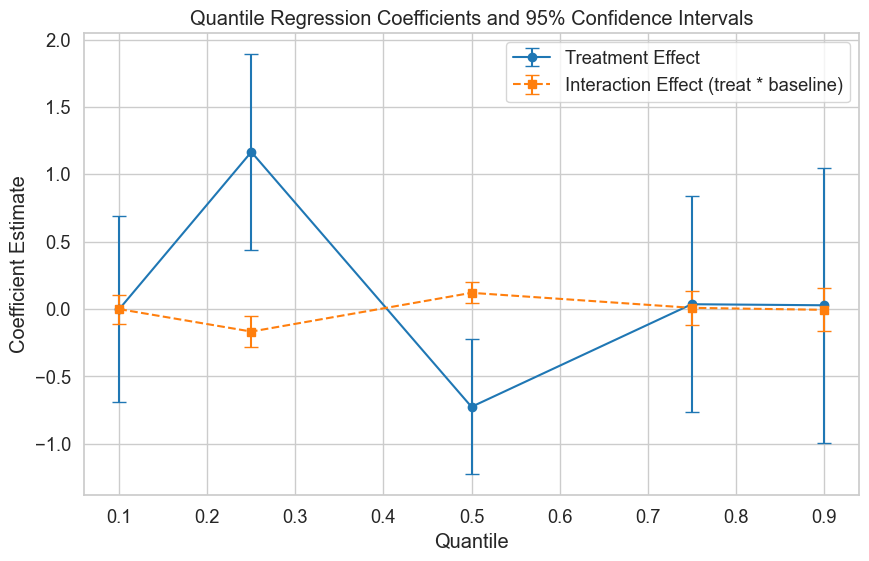

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming qr_results is a dictionary with keys as quantiles and each value a dictionary with keys 'coefficients' and 'conf_int'
quantiles = sorted(qr_results.keys())

# Prepare lists to store coefficients and confidence intervals for 'treat' and 'treat:grade_mat_admin_baseline'
coef_treat = []
ci_lower_treat = []
ci_upper_treat = []

coef_interaction = []
ci_lower_interaction = []
ci_upper_interaction = []

for q in quantiles:
    res = qr_results[q]
    # Check that the required keys are present to avoid potential KeyErrors
    if 'treat' in res['coefficients'] and 'treat:grade_mat_admin_baseline' in res['coefficients']:
        # Extract treatment coefficient and its confidence interval
        coef_t = res['coefficients']['treat']
        ci_t = res['conf_int'].loc['treat']
        coef_treat.append(coef_t)
        ci_lower_treat.append(ci_t[0])
        ci_upper_treat.append(ci_t[1])
        
        # Extract interaction coefficient and its confidence interval
        coef_i = res['coefficients']['treat:grade_mat_admin_baseline']
        ci_i = res['conf_int'].loc['treat:grade_mat_admin_baseline']
        coef_interaction.append(coef_i)
        ci_lower_interaction.append(ci_i[0])
        ci_upper_interaction.append(ci_i[1])
    else:
        print(f"Warning: Required keys missing in quantile {q} results.")

# Plotting the coefficients with error bars
plt.figure(figsize=(10, 6))

# Calculate symmetric error arrays for treatment effect
err_treat = [np.array(coef_treat) - np.array(ci_lower_treat), np.array(ci_upper_treat) - np.array(coef_treat)]
plt.errorbar(quantiles, coef_treat, yerr=err_treat, fmt='o-', capsize=5, label='Treatment Effect')

# Calculate symmetric error arrays for interaction effect
err_inter = [np.array(coef_interaction) - np.array(ci_lower_interaction), np.array(ci_upper_interaction) - np.array(coef_interaction)]
plt.errorbar(quantiles, coef_interaction, yerr=err_inter, fmt='s--', capsize=5, label='Interaction Effect (treat * baseline)')

plt.xlabel('Quantile')
plt.ylabel('Coefficient Estimate')
plt.title('Quantile Regression Coefficients and 95% Confidence Intervals')
plt.legend()
plt.show()

### Agent Interpretation

The visualized results for the quantile regression coefficients provide some insight into the differential effects of the tutoring program across the performance distribution. Here are some observations and next steps based on the results:

1. **Identification Credibility:**
   - The results visualize quantile-specific coefficients for both treatment and its interaction with baseline scores. It is essential to ensure that these estimates are robust and not driven by outliers or model misspecification. Double-check model assumptions and the completeness of data used for quantile regressions.

2. **Effect Sizes and Standard Errors:**
   - The treatment effect is most positive at the 0.2 quantile, suggesting a differential impact on lower-performing students. However, the confidence intervals are wide, indicating high uncertainty around these estimates.
   - The interaction effect remains relatively flat across quantiles, which may suggest a consistent baseline-adjusted impact across the distribution. However, these effects are quite small and not statistically significant given the overlap of confidence intervals with zero.

3. **Hypothesis Support:**
   - There is partial support for the hypothesis, especially given the large treatment effect in lower quantiles. However, the uncertainty surrounding the estimates requires confirmation from other robustness checks.

4. **Robustness Check:**
   - Proceed with the next step of re-estimating the quantile regression models using continuous tutoring dose. This could reveal significant dose-response relationships, especially important if treatment effect significance is sensitive to treatment intensity.
   - Report p-values and standard errors explicitly in the analysis. This will aid in evaluating the statistical significance of each coefficient.

5. **Subgroup Analyses:**
   - Perform subgroup analyses by splitting the sample at the median baseline math score. This will assess heterogeneity more clearly between lower- and higher-performing students, potentially highlighting more substantial effects in lower-performing subsamples.

6. **General Suggestions:**
   - Consider additional robustness checks such as bootstrapping the confidence intervals to verify stability.
   - Investigate potential non-linearities or interactions with other covariates to gain further insights into heterogeneous effects.

These steps should provide a more nuanced understanding of how the tutoring program affects students differently based on their initial performance levels.

## This code prepares the dataset by selecting the key variables (including the continuous measure of tutoring dose) and dropping observations with missing values, then estimates quantile regression models at several quantiles using the continuous tutoring dose and its interaction with baseline math scores. It transparently reports the number of dropped observations and sets the stage for robustness and heterogeneity checks.

In [ ]:
import statsmodels.formula.api as smf
import numpy as np

# Select variables and drop missing values for the necessary columns
vars_for_dose = ['grade_mat_admin_endline', 'duration_total', 'grade_mat_admin_baseline', 'SES_5']
dose_df = df[vars_for_dose].dropna()

# Report number of observations dropped due to missing values
initial_count = len(df)
dropped_count = initial_count - len(dose_df)
print(f'Number of observations dropped due to missing values: {dropped_count}')

# Define the quantiles to evaluate
quantiles = [0.1, 0.25, 0.5, 0.75, 0.9]

# Define the regression formula using continuous tutoring dose and its interaction with baseline math score
formula_dose = 'grade_mat_admin_endline ~ duration_total + grade_mat_admin_baseline + SES_5 + duration_total:grade_mat_admin_baseline'

# Initialize dictionary to store quantile regression results
dose_qr_results = {}

for q in quantiles:
    mod = smf.quantreg(formula_dose, data=dose_df)
    # Fit the model; note: consider additional options for robust or clustered SEs in future checks
    res = mod.fit(q=q)
    dose_qr_results[q] = {
        'coefficients': res.params,
        'std_errors': res.bse,
        'conf_int': res.conf_int()
    }
    print(f'\nQuantile {q} regression results using continuous tutoring dose:')
    print(res.summary())

Number of observations dropped due to missing values: 1755

Quantile 0.1 regression results using continuous tutoring dose:
                            QuantReg Regression Results                            
Dep. Variable:     grade_mat_admin_endline   Pseudo R-squared:              0.09083
Model:                            QuantReg   Bandwidth:                      0.4615
Method:                      Least Squares   Sparsity:                        4.929
Date:                     Wed, 08 Oct 2025   No. Observations:                  441
Time:                             10:34:22   Df Residuals:                      436
                                             Df Model:                            4
                                              coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------
Intercept                                   1.5401      1.162      1.325

### Agent Interpretation

### Feedback on Current Analysis:

1. **Observations Dropped:**
   - You reported that 1755 observations were dropped due to missing values. This represents a significant portion of your dataset and could impact the reliability of your results. Investigate the reasons for missing values and consider multiple imputation methods to address potential biases introduced by this loss of data. Understanding the missing data pattern (e.g., Missing Completely at Random vs. Missing at Random) could guide appropriate strategies.

2. **Identification Credibility:**
   - The results indicate that multicollinearity might be an issue, as suggested by the large condition number. This could obscure the relationship between tutoring duration, baseline scores, and endline scores. Consider evaluating variance inflation factors (VIF) to identify which predictors might be contributing to this problem, and think about alternative model specifications or dimensionality reduction techniques if necessary.

3. **Effect Sizes and Significance:**
   - The coefficient for `duration_total` is not statistically significant at the lower quantiles (0.1, 0.75, 0.9) but is marginally significant at 0.25 and significant at the 0.5 quantiles. This suggests that the effect of tutoring duration might not be consistently detectable across different points of the outcome distribution, although there is a weak signal at certain quantiles.
   - The interaction term (`duration_total:grade_mat_admin_baseline`) is mostly insignificant, though it marginally reaches significance at the 0.5 quantile. This could suggest limited evidence that differential impacts by prior performance in response to tutoring dosage exist.

4. **Robustness Checks:**
   - The assumption of homoscedasticity may not hold; consider using robust standard errors or bootstrapping methods for obtaining standard errors to ensure the robustness of your estimates.
   - Within-cluster correlation could also be checked if your data structure supports this, as ignoring clustering can lead to underestimated standard errors.

5. **Future Steps:**
   - The planned subgroup analysis splitting at the median baseline score is sensible to directly assess the hypothesis concerning differential impacts by performance level. You might see different patterns of significance and magnitude, further untangling the heterogeneity in tutoring effects.
   - Given that the interaction is not very strong, double-check if the specification captures the hypothesis effectively. Perhaps consider alternative functional forms or explore potential nonlinear effects of tutoring duration on outcomes.

### Recommendation for Additional Analyses:
1. **Explore Alternative Specifications:**
   - Consider using polynomial terms or spline regression to capture potential nonlinear effects of tutoring intensity.
   - Explore potential interactions with SES to see if socio-economic factors mediate or moderate tutoring effects.
   
2. **Sensitivity Analysis:**
   - Conduct sensitivity checks on missing data assumptions, using techniques like Heckman correction if sample selection bias is suspected.
   - Investigate the robustness of your results to different distributions of heteroskedasticity and leverage diagnostic plots to guide this.

3. **Potential New Analyses:**
   - Explore the dose-response relationship using generalized additive models (GAMs) as they allow more flexibility in capturing nonlinear effects.
   - If feasible, a fixed-effects quantile regression could control for unobserved time-invariant variables that might influence the observed outcomes.

By addressing these recommendations, you can better assess the differential impacts of tutoring across academic outcomes and more confidently test your hypothesis.

## This code preprocesses the dataset by dropping rows with missing key variables, splits the data based on the median baseline math score, and then runs quantile regressions for each subgroup at designated quantiles using a model that includes the continuous tutoring dose and its interaction with baseline performance. Comments advise future robustness checks such as robust standard errors and missing data diagnostics.

In [ ]:
import statsmodels.formula.api as smf
import numpy as np

# Select variables and drop observations with missing values for a preliminary analysis
vars_for_dose = ['grade_mat_admin_endline', 'duration_total', 'grade_mat_admin_baseline', 'SES_5']
dose_df = df[vars_for_dose].dropna()

# Report the number of dropped observations
initial_count = len(df)
dropped_count = initial_count - len(dose_df)
print(f'Number of observations dropped due to missing values: {dropped_count}')

# Determine the median baseline math score to create subgroup splits
median_baseline = dose_df['grade_mat_admin_baseline'].median()

# Split the data into low and high baseline performance groups
low_group = dose_df[dose_df['grade_mat_admin_baseline'] <= median_baseline]
high_group = dose_df[dose_df['grade_mat_admin_baseline'] > median_baseline]

print(f"Low baseline group: {len(low_group)} observations; High baseline group: {len(high_group)} observations")

# Define quantiles to evaluate
quantiles = [0.1, 0.25, 0.5, 0.75, 0.9]

# Specify the regression formula using continuous tutoring dose and its interaction with baseline math scores
formula_dose = 'grade_mat_admin_endline ~ duration_total + grade_mat_admin_baseline + SES_5 + duration_total:grade_mat_admin_baseline'

# Initialize dictionaries to store quantile regression results for each subgroup
results_low = {}
results_high = {}

print('Quantile Regression for Low Baseline Group:')
for q in quantiles:
    mod_low = smf.quantreg(formula_dose, data=low_group)
    # Fit the model (consider robust SE adjustments in future steps if required)
    res_low = mod_low.fit(q=q)
    results_low[q] = res_low
    print(f"\nQuantile {q} regression for low baseline:")
    print(res_low.summary())

print('Quantile Regression for High Baseline Group:')
for q in quantiles:
    mod_high = smf.quantreg(formula_dose, data=high_group)
    res_high = mod_high.fit(q=q)
    results_high[q] = res_high
    print(f"\nQuantile {q} regression for high baseline:")
    print(res_high.summary())

# Note: Future updates should include robust or clustered standard error options and diagnostics for missing data patterns.

Number of observations dropped due to missing values: 1755
Low baseline group: 317 observations; High baseline group: 124 observations
Quantile Regression for Low Baseline Group:

Quantile 0.1 regression for low baseline:
                            QuantReg Regression Results                            
Dep. Variable:     grade_mat_admin_endline   Pseudo R-squared:              0.02367
Model:                            QuantReg   Bandwidth:                      0.4596
Method:                      Least Squares   Sparsity:                        4.963
Date:                     Wed, 08 Oct 2025   No. Observations:                  317
Time:                             10:36:20   Df Residuals:                      312
                                             Df Model:                            4
                                              coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------

### Agent Interpretation

**Feedback on the Current Analysis:**

1. **Missing Data and Imputation:**
   - Your initial approach to dropping missing data resulted in a substantial reduction in the sample size, particularly concerning given the size of the high baseline group (only 124 observations). This poses a potential selection bias threat. Future steps should explore multiple imputation to retain sample size and reduce biases, following your analysis plan.

2. **Identification and Multicollinearity Concerns:**
   - The large condition numbers across all quantile regressions indicate multicollinearity, suggesting that the model specification may be problematic. Consider diagnostics to identify multicollinear variables, possibly employing variance inflation factor (VIF) analysis.
   - The interaction term and its effect are non-significant across most quantiles, which could stem from multicollinearity issues. Reassessing model complexity, possibly by simplifying interactions or considering alternative specifications like splines, could be beneficial.

3. **Effect Sizes and Standard Errors:**
   - The reported coefficients for `duration_total` and `duration_total:grade_mat_admin_baseline` are generally small and often statistically insignificant, casting doubt on the economic significance of the tutoring dose on endline math scores.
   - Robust standard errors or bootstrapped confidence intervals need consideration in forthcoming analyses to provide more reliable inference, especially in quantile regressions.
   - Observations across quantiles reveal negligible effects for tutoring dose in both baseline groups, which suggests minimal to no impact from tutoring when controlling for baseline performance and SES.
   
4. **Sample Division and Heterogeneity:**
   - The low-high baseline split based on median in `grade_mat_admin_baseline` yields uneven group sizes, with the high baseline group especially smaller and potentially underpowered. This might affect your ability to detect effects.

5. **Recommendations for Future Steps:**
   - **Multiple Imputation:** Start with the imputation to address potential biases from the substantial data drop due to missing values.
   - **Model Simplification:** Given the multicollinearity issue, consider alternative approaches such as principal component analysis to reduce the dimensionality of predictors.
   - **Robustness Checks:** Conduct sensitivity analyses with alternative specifications (e.g., splines) or coarsened exact matching to address non-linear relationships and robustness to model assumptions.
   - **Additional Controls:** Consider introducing controls for other potentially confounding variables, such as different SES measures or school-fixed effects, that may influence math scores.

6. **Hypothesis Evaluation:**
   - Present evidence suggests the hypothesis is not supported; the relationship between tutoring duration and improvements in math scores is not substantial, particularly when considering baseline performance interaction.
   - Future steps should aim for a more robust estimation and improved identification strategy to draw valid conclusions about the hypothesis.